## Imports

In [1]:
import multiprocessing
import os
import pickle
import time

import energyflow as ef
from energyflow.datasets import mod

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from scipy.stats import gaussian_kde, rankdata
from pyclustering.cluster import kmedoids

import utils
import modplot

## Options

In [7]:
num4emd_str = '40k'
ptmin, ptmax = (399, 401)
rotate = True
filtname = 'TracksPFCpTCut'
reprocess = True

n_iter, perplexity, method = 2000, 30, 'exact'

dsets = ['cms', 'sim', 'gen']
dset_names = ['CMS 2011 Open Data', 'CMS 2011 Simulation', r'\textsc{Pythia 6} Generation']
dset_paths = ['cms', 'sim', 'sim']
names = ['CMS_Jet300_pT{}-{}GeV_EtaMax19_Quality2_{}', 'SIM_Jet300_pT{}-{}GeV_EtaMax19_Quality2_{}', 
         'GEN_pT{}-{}GeV_EtaMax19_{}']

rot_str = '_Rotated' if rotate else ''

filters = {
    'All': {'which': 'all', 'pt_cut': None, 'chs': True},
    'PFCpTCut': {'which': 'all', 'pt_cut': 1.0, 'chs': True},
    'Tracks': {'which': 'charged', 'pt_cut': None, 'chs': True},
    'TracksPFCpTCut': {'which': 'charged', 'pt_cut': 1.0, 'chs': True},
}

filtstamps = {
    'All': 'CHS',
    'PFCpTCut': r'CHS, $p_T^{\mathrm{PFC}}>1$ GeV',
    'Tracks': 'CHS, Tracks Only',
    'TracksPFCpTCut': r'CHS, Tracks, $p_T^{\mathrm{PFC}}>1$ GeV',
}

# colors
blue = np.asarray([0.0, 0.6235294117647059, 1.0])
red = np.asarray([0.9254901960784314, 0.1843137254901961, 0.29411764705882354])

cdict = {'red':   ((0, blue[0], blue[0]),
                   (1, red[0],  red[0])),
         'green': ((0, blue[1], blue[1]),
                   (1, red[1],  red[1])),
         'blue':  ((0, blue[2], blue[2]),
                   (1, red[2],  red[2]))}

cmap = matplotlib.colors.LinearSegmentedColormap('evening_sunshine', cdict)

## Load MOD Datasets and EMDs

In [3]:
moddss, emdss = [], []
for dset,name,dset_path in zip(dsets, names, dset_paths):
    start = time.time()

    name = name.format(ptmin, ptmax, num4emd_str)
    dset_path = (dset if dset != 'gen' else 'sim')
    modds = ef.datasets.mod.MODDataset(name, path=utils.path(dset_path, 'h5'))

    emd_name = '{}_{}{}'.format(name, filtname, rot_str)
    emds = np.load(utils.path(dset_path, 'emds', emd_name + '.npy'))

    if np.any(emds < 0):
        pos_mask = ~np.all(emds <= 0, axis=0)
        emds = emds[pos_mask][:,pos_mask]

        modds.apply_mask(pos_mask)

    moddss.append(modds)
    emdss.append(emds)

    print('Loaded MODDataset and EMDs for {} in {:.3f}s'.format(emd_name, time.time() - start))

Loaded MODDataset and EMDs for CMS_Jet300_pT399-401GeV_EtaMax19_Quality2_40k_TracksPFCpTCut_Rotated in 117.454s
Loaded MODDataset and EMDs for SIM_Jet300_pT399-401GeV_EtaMax19_Quality2_40k_TracksPFCpTCut_Rotated in 157.872s
Loaded MODDataset and EMDs for GEN_pT399-401GeV_EtaMax19_40k_TracksPFCpTCut_Rotated in 141.657s


In [4]:
R = 0.5
particles = []
for j in range(3):
    start = time.time()
    modds = moddss[j]
    particles_j = []
    
    for i in range(len(modds)):
        particles_i = modds.particles[i]

        particles_i = particles_i[utils.filter_particles(particles_i, **filters[filtname]),:3]
        particles_i = ef.center_ptyphims(particles_i, center='escheme')
        if rotate:
            particles_i = ef.rotate_ptyphims(particles_i)
        particles_i = particles_i[np.linalg.norm(particles_i[:,1:3], axis=1) <= R]
        particles_i[:,0] *= 400./particles_i[:,0].sum()

        particles_j.append(particles_i)
        
    particles.append(particles_j)
    print('Finished filtering particles for {} in {:.3f}s'.format(dsets[j], time.time() - start))

Finished filtering particles for cms in 11.904s
Finished filtering particles for sim in 14.268s
Finished filtering particles for gen in 14.191s


In [17]:
for j in range(3):
    for i in range(len(particles[j])):
        ptsum = particles[j][i][:,0].sum()
        if np.abs(ptsum - 400.) > 10**-12:
            print(j, i, 'pts sum to', ptsum)

## tSNE

In [14]:
def train_tsne(i):
    start = time.time()
    tsne = TSNE(n_components=2, metric='precomputed', verbose=2,
                n_iter=n_iter, perplexity=perplexity, method=method)
    tsne.fit(emdss[i]/400.)
    
    args = (dsets[i].upper(), filtname, num4emd_str, rot_str, method, n_iter, perplexity)
    filename = 'tSNE_{}_{}_{}{}_method-{}_niter-{}_perplexity-{}.npy'.format(*args)
    filepath = utils.path(dset_paths[i], 'plotdata', filename)
    np.save(filepath, tsne.embedding_)
    
    print(args[0], 'KL divergence:', tsne.kl_divergence_)
    print(args[0], 'finished and saved in {:.3f}s'.format(time.time() - start))

In [10]:
with multiprocessing.Pool(processes=3) as pool:
    list(pool.map(train_tsne, range(3), chunksize=1))

[t-SNE] Computed conditional probabilities for sample 1000 / 33982
[t-SNE] Computed conditional probabilities for sample 1000 / 40146
[t-SNE] Computed conditional probabilities for sample 1000 / 40198
[t-SNE] Computed conditional probabilities for sample 2000 / 33982
[t-SNE] Computed conditional probabilities for sample 2000 / 40146
[t-SNE] Computed conditional probabilities for sample 2000 / 40198
[t-SNE] Computed conditional probabilities for sample 3000 / 33982
[t-SNE] Computed conditional probabilities for sample 3000 / 40146
[t-SNE] Computed conditional probabilities for sample 3000 / 40198
[t-SNE] Computed conditional probabilities for sample 4000 / 33982
[t-SNE] Computed conditional probabilities for sample 5000 / 33982
[t-SNE] Computed conditional probabilities for sample 4000 / 40146
[t-SNE] Computed conditional probabilities for sample 4000 / 40198
[t-SNE] Computed conditional probabilities for sample 6000 / 33982
[t-SNE] Computed conditional probabilities for sample 5000 / 4

[t-SNE] Iteration 100: error = 102.3792825, gradient norm = 0.0018189 (50 iterations in 4120.830s)
[t-SNE] Iteration 150: error = 99.9689705, gradient norm = 0.0001438 (50 iterations in 4059.278s)
[t-SNE] Iteration 100: error = 105.9284087, gradient norm = 0.0029823 (50 iterations in 5779.794s)
[t-SNE] Iteration 100: error = 105.2617219, gradient norm = 0.0020502 (50 iterations in 5791.330s)
[t-SNE] Iteration 200: error = 99.8107098, gradient norm = 0.0000227 (50 iterations in 4121.243s)
[t-SNE] Iteration 150: error = 101.5401283, gradient norm = 0.0002026 (50 iterations in 5734.276s)
[t-SNE] Iteration 150: error = 102.4077814, gradient norm = 0.0000911 (50 iterations in 5746.488s)
[t-SNE] Iteration 250: error = 99.8040632, gradient norm = 0.0000067 (50 iterations in 4043.199s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 99.804063
[t-SNE] Iteration 300: error = 4.6602430, gradient norm = 0.0011708 (50 iterations in 4066.768s)
[t-SNE] Iteration 200: error = 101.3

[t-SNE] Iteration 1800: error = 3.0730515, gradient norm = 0.0000249 (50 iterations in 4128.967s)
[t-SNE] Iteration 1850: error = 3.0656990, gradient norm = 0.0000238 (50 iterations in 4116.466s)
[t-SNE] Iteration 1300: error = 3.4133303, gradient norm = 0.0000398 (50 iterations in 5776.112s)
[t-SNE] Iteration 1300: error = 3.3462741, gradient norm = 0.0000398 (50 iterations in 5776.743s)
[t-SNE] Iteration 1900: error = 3.0587276, gradient norm = 0.0000229 (50 iterations in 4157.695s)
[t-SNE] Iteration 1350: error = 3.3313997, gradient norm = 0.0000375 (50 iterations in 5815.574s)
[t-SNE] Iteration 1350: error = 3.3982007, gradient norm = 0.0000378 (50 iterations in 5836.815s)
[t-SNE] Iteration 1950: error = 3.0521125, gradient norm = 0.0000221 (50 iterations in 4101.007s)
[t-SNE] Iteration 1400: error = 3.3174724, gradient norm = 0.0000355 (50 iterations in 5793.818s)
[t-SNE] Iteration 1400: error = 3.3840672, gradient norm = 0.0000360 (50 iterations in 5780.322s)
[t-SNE] Iteration 20

In [8]:
embeddings = []
for i in range(3):
    args = (dsets[i].upper(), filtname, num4emd_str, rot_str, method, n_iter, perplexity)
    filename = 'tSNE_{}_{}_{}{}_method-{}_niter-{}_perplexity-{}.npy'.format(*args)
    filepath = utils.path(dset_paths[i], 'plotdata', filename)
    embeddings.append(np.load(filepath))
    
obss = [[ef.sum_ptyphims(p)[3] for p in particles[i]] for i in range(3)]

## Processing

In [15]:
filepath = os.path.join(utils.DATAPATH, 'plotdata', 'tSNE_AllPlotdata.pickle')
if reprocess:

    angles = [200, 85, 5]
    xlims = [(-130, 145), (-130, 145), (-130, 145)]
    ylims = [(-135, 140), (-135, 140), (-135, 140)]
    refs = [(1, -1), (1, 1), (1, 1)]

    contours, ptyphis, xys, colors, Rxs, Rys = [], [], [], [], [], []
    for i in range(3):
        start = time.time()

        theta = angles[i]/180*np.pi
        rot = np.asarray([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

        # show individual jets
        jet_R, ncirc, delta, zf = 0.5, 40, 1.1, 40

        xys_i = embeddings[i].T
        xys_i -= np.mean(xys_i, axis=1)[:,np.newaxis]
        xys_i = np.dot(rot, xys_i)
        xys_i = xys_i.T
        xys_i *= refs[i]

        xmin, xmax = xlims[i][0], xlims[i][1]
        ymin, ymax = ylims[i][0], ylims[i][1]

        # kernel density estimate
        n_kernel_pts = 100
        Xs, Ys = np.mgrid[xmin:xmax:n_kernel_pts*1j, ymin:ymax:n_kernel_pts*1j]
        positions = np.vstack([Xs.ravel(), Ys.ravel()])
        kernel = gaussian_kde(xys_i.T, bw_method=None)
        Zs = kernel(positions).reshape(n_kernel_pts, n_kernel_pts)
        
        Rx = (xmax - xmin)/ncirc/jet_R/2
        Ry = (ymax - ymin)/ncirc/jet_R/2
        
        # determine non-overlapping inds
        perm = np.random.permutation(len(xys_i))
        inds_i = []
        for p,(x,y) in zip(perm, xys_i[perm]):
            
            good = True
            for j in inds_i:
                if (x - xys_i[j,0])**2/Rx**2 + (y - xys_i[j,1])**2/Ry**2 < delta*4:
                    good = False
                    break
            if good:
                inds_i.append(p)
        
        # get particles
        ranked_masses = (rankdata(obss[i]) - 1)/len(obss[i])
        ptyphis_i, colors_i, xys_j = [], [], []
        for ind in inds_i:
            x, y = xys_i[ind]
            if y < -100 or y > 100:
                continue
                
            xys_j.append((x, y))

            zs, ys, phis = particles[i][ind][:,:3].T
            ptyphis_i.append((zs*zf/zs.sum(), Rx*ys, Ry*phis))

            lam = ranked_masses[ind]
            colors_i.append((1 - lam)*blue + lam*red)
            
        # append to arrays
        contours.append((Xs, Ys, Zs))
        ptyphis.append(ptyphis_i)
        xys.append(xys_j)
        colors.append(colors_i)
        Rxs.append(Rx)
        Rys.append(Ry)
        
        print('Processed {} in {:.3f}s'.format(dsets[i].upper(), time.time() - start))

    with open(filepath, 'wb') as f:
        pickle.dump({'xlims': xlims, 'ylims': ylims, 'Rxs': Rxs, 'Rys': Rys,
                     'contours': contours, 'ptyphis': ptyphis, 'xys': xys, 'colors': colors}, f)
        print('Saved tSNE plot data')
    
# load in already saved information
else:
    
    f = np.load(filepath, allow_pickle=True)
    xlims, ylims, Rxs, Rys = f['xlims'], f['ylims'], f['Rxs'], f['Rys']
    contours, ptyphis, xys, colors = f['contours'], f['ptyphis'], f['xys'], f['colors']
    print('Loaded tSNE plot data')

Processed CMS in 7.213s
Processed SIM in 8.433s
Processed GEN in 8.308s
Saved tSNE plot data


## Make Plots

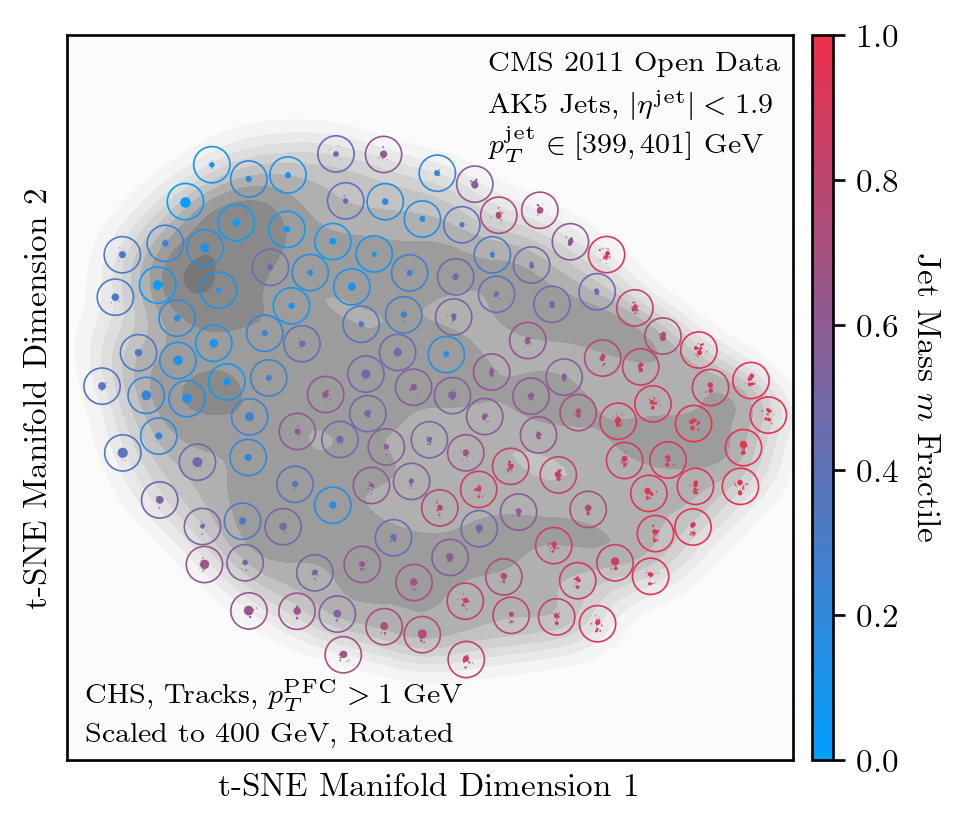

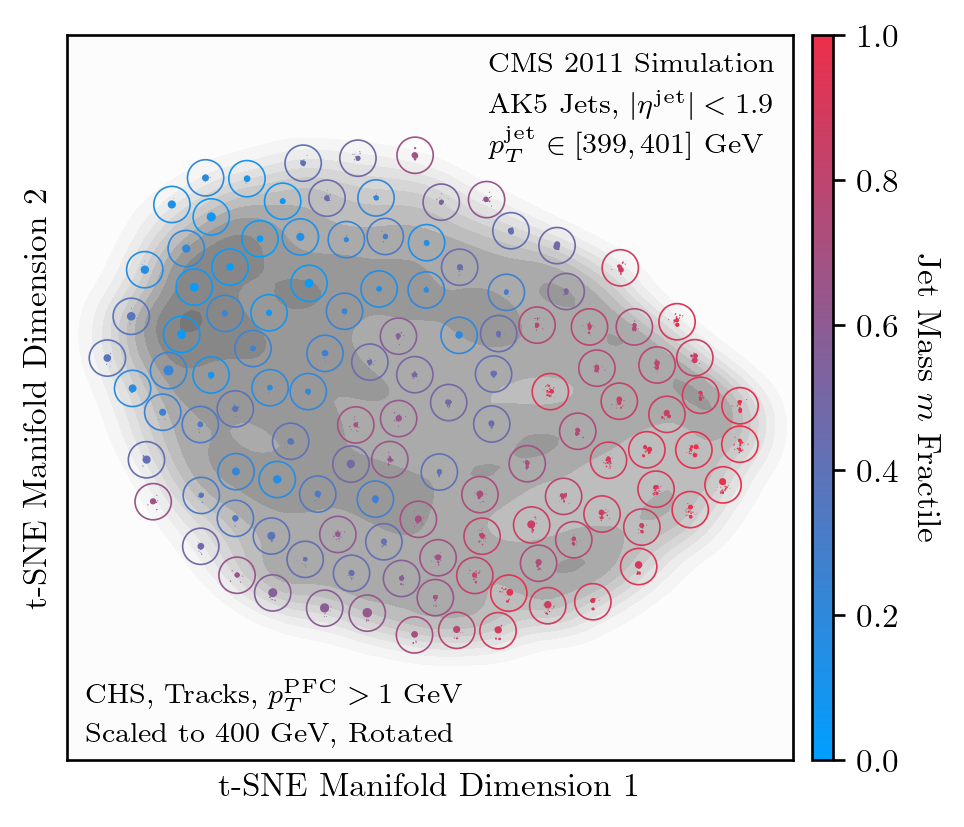

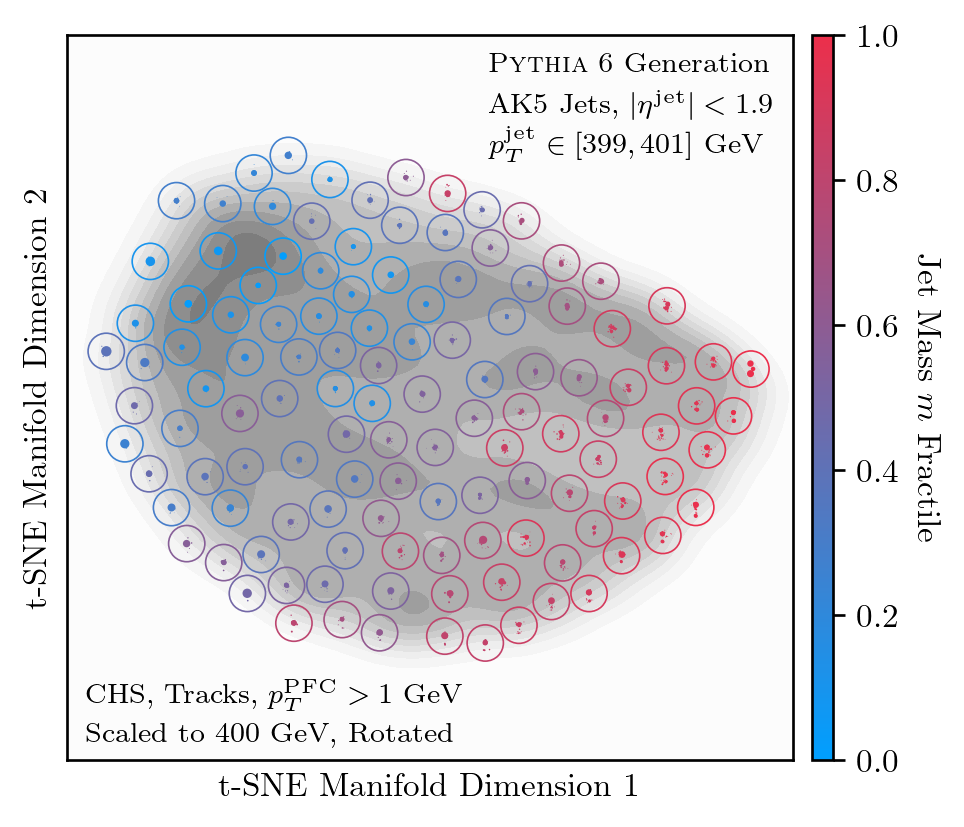

In [16]:
for i in range(3):

    fig = plt.figure(figsize=(4.15,4))

    plt.xticks([])
    plt.yticks([])
    plt.xlabel('t-SNE Manifold Dimension 1')
    plt.ylabel('t-SNE Manifold Dimension 2')
    plt.xlim(*xlims[i])
    plt.ylim(*ylims[i])

    # plot kde
    Xs, Ys, Zs = contours[i]
    plt.contourf(Xs, Ys, Zs, 10, cmap='Greys', vmin=0, vmax=1.7*np.max(Zs))

    # plot jets
    for ptyphi,xy,c in zip(ptyphis[i], xys[i], colors[i]):
        x, y = xy
        plt.scatter(x + ptyphi[1], y + ptyphi[2], s=ptyphi[0], marker='.', lw=0, color=c)
        plt.gca().add_patch(matplotlib.patches.Ellipse((x, y), 2*Rxs[i], 2*Rys[i], fill=None, 
                                                       edgecolor=c, lw=0.5))

    cbar = plt.colorbar(matplotlib.cm.ScalarMappable(cmap=cmap), fraction=0.035, pad=0.025, aspect=35)
    cbar.set_label(r'Jet Mass $m$ Fractile', rotation=270, labelpad=12.5)
    
    modplot.stamp(0.58, 0.96, delta_y=0.055,
                  line_0=dset_names[i], 
                  line_1=r'AK5 Jets, $|\eta^{\rm jet}|<1.9$',
                  line_2=r'$p_T^{\rm jet}\in[399,401]$ GeV')

    modplot.stamp(0.025, .09, delta_y=0.055,
                  line_0=filtstamps[filtname],
                  line_1='Scaled to 400 GeV, Rotated')

    modplot.save(fig, out_plots_dir='../plots/tSNE/', name='tSNE_{}_{}'.format(dsets[i].upper(), num4emd_str), 
                 tx=19.25, ty = 238.5)
    fig.show()

## Overlayed Medoids

In [ ]:
k = 25

def get_kmedoids_all(i):
    start = time.time()
    np.random.seed(i)
    initials = np.random.randint(len(emdss[dset_i]), size=k)
    kmeds = kmedoids.kmedoids(emdss[dset_i], initials, data_type='distance_matrix', tolerance=0.0001)
    kmeds.process()

    name = '{}_kMedoids_all_{}-{}GeV_{}.pickle'.format(dsets[dset_i].upper(), ptmin, ptmax, i)
    with open(os.path.join(utils.DATAPATH, 'plotdata', 'kmedoids', name), 'wb') as f:
        pickle.dump(kmeds.get_medoids(), f)

if reprocess:
    
    nruns = [1000, 24, 24]
    for dset_i in [1, 2, 0]:
        start = time.time()
        with multiprocessing.Pool(processes=8) as pool:
            print(dsets[dset_i].upper())
            for i,_ in enumerate(pool.imap_unordered(get_kmedoids_all, range(nruns[dset_i]), chunksize=1)):
                if (i+1) % 8 == 0:
                    print('  Computed {} kMedoids in {:.3f}s'.format(i+1, time.time() - start))
            print()

In [22]:
filepath = os.path.join(utils.DATAPATH, 'plotdata', 'tSNE_kMedoids_plotdata.pickle')
if reprocess and 0:
    
    angles = [200, 85, 5]
    refs = [(1, -1), (1, 1), (1, 1)]
    zf, sf, lw = 2500, 0.65, 18
    kmedoid_run_inds = [630, 9, 13]
    
    ptyphis, colors, xys, Rxs, Rys, lws = [], [], [], [], [], []
    for i in range(3):
        
        theta = angles[i]/180*np.pi
        rot = np.asarray([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])

        xys_i = np.copy(embeddings[i])
        xys_i -= np.mean(xys_i, axis=0)
        xys_i = np.dot(xys_i, rot)
        xys_i *= refs[i]
        
        xmin, xmax = xlims[i][0], xlims[i][1]
        ymin, ymax = ylims[i][0], ylims[i][1]
        
        Rx_g = sf*(xmax - xmin)/2
        Ry_g = sf*(ymax - ymin)/2
        
        ranked_masses = (rankdata(obss[i]) - 1)/len(obss[i])

        kri = kmedoid_run_inds[i]
        name = '{}_kMedoids_all_{}-{}GeV_{}.pickle'.format(dsets[i].upper(), ptmin, ptmax, kri)
        medoids = np.load(os.path.join(utils.DATAPATH, 'plotdata', 'kmedoids', name), allow_pickle=True)

        med_inds, counts = np.unique(np.argmin(emdss[i][medoids], axis=0), return_counts=True)

        ptyphis_i, colors_i, xys_j, Rxs_i, Rys_i, lws_i = [], [], [], [], [], []
        for ind,frac in zip(medoids, counts/np.sum(counts)):

            sqrtfrac = np.sqrt(frac)
            zs, ys, phis = particles[i][ind][:,:3].T
            ptyphis_i.append((frac*zf*zs/zs.sum(), Rx_g*sqrtfrac*ys, Ry_g*sqrtfrac*phis))
            Rxs_i.append(sqrtfrac*Rx_g)
            Rys_i.append(sqrtfrac*Ry_g)
            lws_i.append(frac*lw)

            lam = ranked_masses[ind]
            c = (1 - lam)*blue + lam*red

            xys_j.append(xys_i[ind])
            colors_i.append(c)

        colors.append(colors_i)
        ptyphis.append(ptyphis_i)
        xys.append(xys_j)
        Rxs.append(Rxs_i)
        Rys.append(Rys_i)
        lws.append(lws_i)
        
    with open(filepath, 'wb') as f:
        pickle.dump({'xlims': xlims, 'ylims': ylims, 'Rxs': Rxs, 'Rys': Rys, 'lws': lws,
                     'contours': contours, 'ptyphis': ptyphis, 'xys': xys, 'colors': colors}, f)
        print('Saved tSNE plot data')
        
else:
    f = np.load(filepath, allow_pickle=True)
    xlims, ylims, Rxs, Rys, lws = f['xlims'], f['ylims'], f['Rxs'], f['Rys'], f['lws']
    contours, ptyphis, xys, colors = f['contours'], f['ptyphis'], f['xys'], f['colors']
    print('Loaded tSNE plot data')

Loaded tSNE plot data


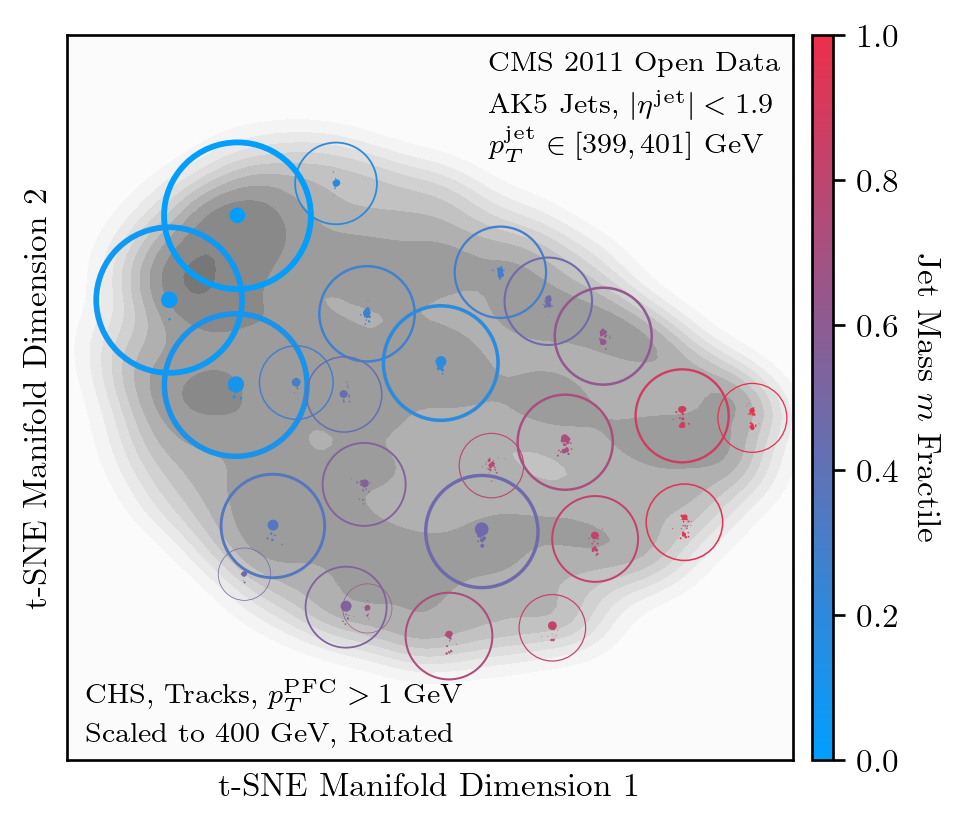

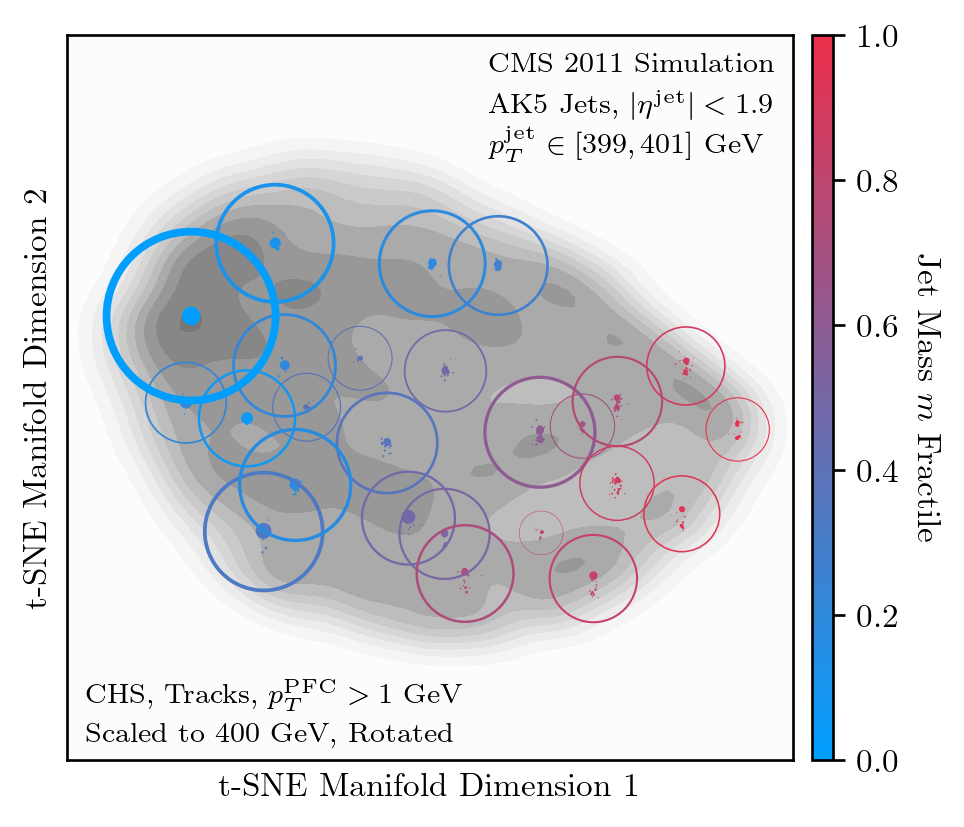

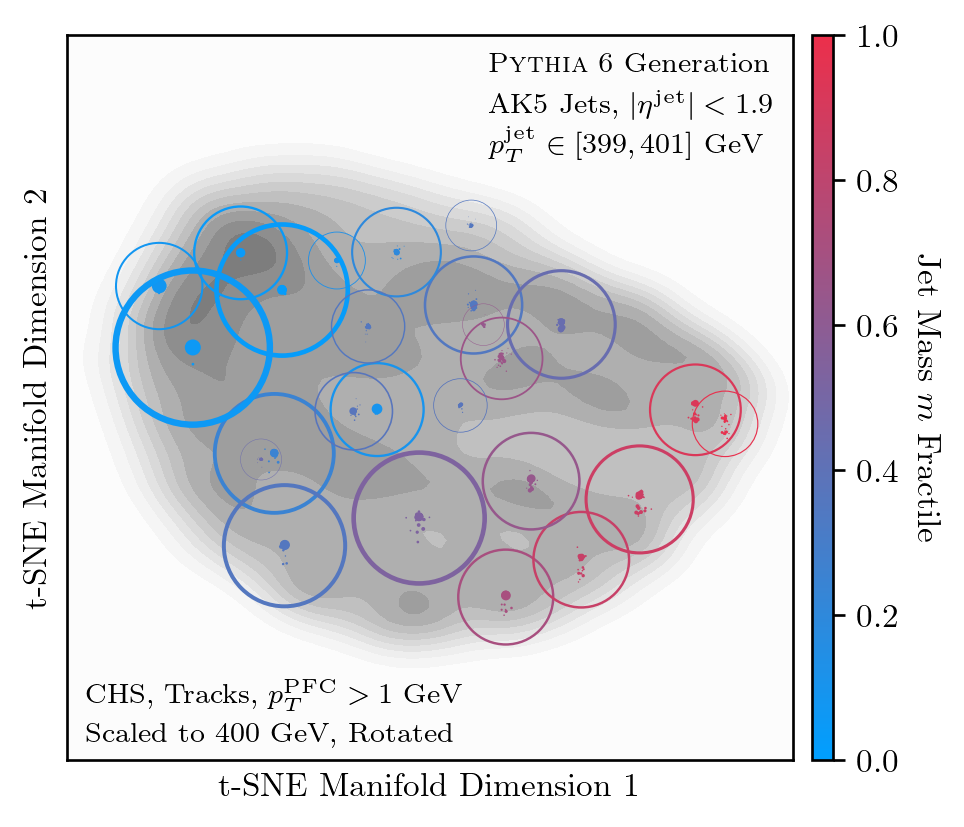

In [25]:
for i in range(3):

    fig = plt.figure(figsize=(4.15,4))

    plt.xticks([])
    plt.yticks([])
    plt.xlabel('t-SNE Manifold Dimension 1')
    plt.ylabel('t-SNE Manifold Dimension 2')
    plt.xlim(*xlims[i])
    plt.ylim(*ylims[i])

    # plot kde
    Xs, Ys, Zs = contours[i]
    plt.contourf(Xs, Ys, Zs, 10, cmap='Greys', vmin=0, vmax=1.7*np.max(Zs))

    # plot jets
    for ptyphi,xy,c,Rx,Ry,lw in zip(ptyphis[i], xys[i], colors[i], Rxs[i], Rys[i], lws[i]):
        x, y = xy
        plt.scatter(x + ptyphi[1], y + ptyphi[2], s=ptyphi[0], marker='.', lw=0, color=c)
        plt.gca().add_patch(matplotlib.patches.Ellipse((x, y), 2*Rx, 2*Ry, fill=None, 
                                                       edgecolor=c, lw=lw))

    cbar = plt.colorbar(matplotlib.cm.ScalarMappable(cmap=cmap), fraction=0.035, pad=0.025, aspect=35)
    cbar.set_label(r'Jet Mass $m$ Fractile', rotation=270, labelpad=12.5)
    
    modplot.stamp(0.58, 0.96, delta_y=0.055,
                  line_0=dset_names[i], 
                  line_1=r'AK5 Jets, $|\eta^{\rm jet}|<1.9$',
                  line_2=r'$p_T^{\rm jet}\in[399,401]$ GeV')

    modplot.stamp(0.025, .09, delta_y=0.055,
                  line_0=filtstamps[filtname],
                  line_1='Scaled to 400 GeV, Rotated')

    name = 'tSNE-kMedoids_{}_{}'.format(dsets[i].upper(), num4emd_str)
    modplot.save(fig, name, out_plots_dir='../plots/tSNE/',tx=19.25, ty = 238.5)
    fig.show()